In [262]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import comb
import math
from scipy.optimize import fsolve
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
import datetime;
import warnings
warnings.filterwarnings("ignore")

# 1. Load the DS Model

In [64]:
"""
We use ICLR 2020 and L=4 as an example. One can change these two parameters to switch to different models.
"""
year = 2020 # either 2020 or 2021
L = 4 # either 4 or 5

w = np.load('Learned Model/w_'+str(year)[2:]+'_L'+str(L)+'.npy')
Gamma = np.load('Learned Model/Gamma_'+str(year)[2:]+'_L'+str(L)+'.npy')
Q = np.load('Learned Model/Q_'+str(year)[2:]+'_L'+str(L)+'.npy')

print('Prior of quality, w = ',np.round(w,4),'\n')
gamma_frame = np.round(Gamma,4)
df = pd.DataFrame(data=gamma_frame)
print('Confusion matrix, Gamma = ')
print(df,'\n')
print('Quality set = ',np.round(Q,4))

Prior of quality, w =  [0.0772 0.3987 0.2648 0.2593] 

Confusion matrix, Gamma = 
        0       1       2       3       4       5       6       7       8  \
0  0.0400  0.1706  0.4200  0.2729  0.0685  0.0028  0.0247  0.0002  0.0002   
1  0.0004  0.0123  0.1195  0.3816  0.2948  0.1288  0.0450  0.0119  0.0056   
2  0.0001  0.0043  0.0226  0.0959  0.3235  0.3626  0.1648  0.0188  0.0073   
3  0.0001  0.0016  0.0090  0.0302  0.0534  0.2922  0.4285  0.1427  0.0375   

        9  
0  0.0001  
1  0.0001  
2  0.0001  
3  0.0048   

Quality set =  [-1.1145 -0.4079  0.0544  0.5606]


# 2. Noiseless Authors

## 2.1. Some Tool Functions

In [109]:
def Mapping_review_to_quality(Gamma):
    """
    Input: "Gamma" is the confusion matrix.
    For each m = 1, ..., 5, the function computes 
    1) an array of all the possible posterior qualities of the paper; 
    2) an array of the probabilities of the occurrence of each of the set of review signals
    """
    global Review_to_quality_1, Review_to_quality_2, Review_to_quality_3, Review_to_quality_4, Review_to_quality_5
    global Review_to_probability_1, Review_to_probability_2, Review_to_probability_3, Review_to_probability_4, Review_to_probability_5
    
    # m = 1
    Review_to_quality_1 = []
    Review_to_probability_1 = []
    for r1 in range(10):
        Review_to_quality_1.append(np.sum((w*Gamma[:,r1]/np.sum(w*Gamma[:,r1]))*Q))
        Review_to_probability_1.append(Gamma[:,r1])
    Review_to_probability_1 = [x for _, x in sorted(zip(Review_to_quality_1, Review_to_probability_1))]
    Review_to_quality_1 = sorted(Review_to_quality_1)

    # m = 2
    Review_to_quality_2 = []
    Review_to_probability_2 = []
    for r1 in range(10):
        for r2 in range(10):
            Review_to_quality_2.append(np.sum((w*Gamma[:,r1]*Gamma[:,r2]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]))*Q))
            Review_to_probability_2.append(Gamma[:,r1]*Gamma[:,r2])

    Review_to_probability_2 = [x for _, x in sorted(zip(Review_to_quality_2, Review_to_probability_2), key = lambda x: x[0])]
    Review_to_quality_2 = sorted(Review_to_quality_2)

    # m = 3
    Review_to_quality_3 = []
    Review_to_probability_3 = []
    for r1 in range(10):
        for r2 in range(10):
            for r3 in range(10):
                Review_to_quality_3.append(np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]))*Q))
                Review_to_probability_3.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3])
    Review_to_probability_3 = [x for _, x in sorted(zip(Review_to_quality_3, Review_to_probability_3), key = lambda x: x[0])]
    Review_to_quality_3 = sorted(Review_to_quality_3)

    # m = 4
    Review_to_quality_4 = []
    Review_to_probability_4 = []
    for r1 in range(10):
        for r2 in range(10):
            for r3 in range(10):
                for r4 in range(10):
                    Review_to_quality_4.append(np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]))*Q))
                    Review_to_probability_4.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4])
    Review_to_probability_4 = [x for _, x in sorted(zip(Review_to_quality_4, Review_to_probability_4), key = lambda x: x[0])]
    Review_to_quality_4 = sorted(Review_to_quality_4)

    # m = 5
    Review_to_quality_5 = []
    Review_to_probability_5 = []
    for r1 in range(10):
        for r2 in range(10):
            for r3 in range(10):
                for r4 in range(10):
                    for r5 in range(10):
                        Review_to_quality_5.append(np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5]))*Q))
                        Review_to_probability_5.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5])
    Review_to_probability_5 = [x for _, x in sorted(zip(Review_to_quality_5, Review_to_probability_5), key = lambda x: x[0])]
    Review_to_quality_5 = sorted(Review_to_quality_5)
    
    
    
    

In [110]:
def P_acc_multi(tau, m, Gamma):
    """
    Input: "tau" is the acceptance threshold; 
           "m" is the number of solicited reviews;
           "Gamma" is the confusion matrix.
    Output: "P_acc" is the probability of acceptance of the papers of each category.
    """
    L = np.size(Gamma, axis = 0)
    P_acc = np.zeros(L)
    if m == 1:
        # if there exists a review signal such that conditional on it, the expected quality of the paper is higher than the threshold
        if len(np.where(Review_to_quality_1 >= tau)[0]) != 0:
            index = np.where(Review_to_quality_1 >= tau)[0][0]
            # if the threshold is very low such that all review signals imply acceptance
            if index == 0:
                P_acc = np.ones(L)
            # intermediate cases
            else:
                P_acc = np.sum(Review_to_probability_1[index:], axis = 0) + (Review_to_quality_1[index] - tau)/(Review_to_quality_1[index]-Review_to_quality_1[index-1])*Review_to_probability_1[index-1]
        
        # if the threshold is very high such that no review signal can guarantee acceptance
        else:
            P_acc = Review_to_probability_1[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_1[-1])
    
    elif m == 2:
        if len(np.where(Review_to_quality_2 >= tau)[0]) != 0:
            index = np.where(Review_to_quality_2 >= tau)[0][0]
            if index == 0:
                P_acc = np.ones(L)
            else:
                P_acc = np.sum(Review_to_probability_2[index:], axis = 0) + (Review_to_quality_2[index] - tau)/(Review_to_quality_2[index]-Review_to_quality_2[index-1])*Review_to_probability_2[index-1]
        else:
            P_acc = Review_to_probability_2[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_2[-1])
    
    elif m == 3:
        if len(np.where(Review_to_quality_3 >= tau)[0]) != 0:
            index = np.where(Review_to_quality_3 >= tau)[0][0]
            if index == 0:
                P_acc = np.ones(L)
            else:
                P_acc = np.sum(Review_to_probability_3[index:], axis = 0) + (Review_to_quality_3[index] - tau)/(Review_to_quality_3[index]-Review_to_quality_3[index-1])*Review_to_probability_3[index-1]
        else:
            P_acc = Review_to_probability_3[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_3[-1])
    
    elif m == 4:
        if len(np.where(Review_to_quality_4 >= tau)[0]) != 0:
            index = np.where(Review_to_quality_4 >= tau)[0][0]
            if index == 0:
                P_acc = np.ones(L)
            else:
                P_acc = np.sum(Review_to_probability_4[index:], axis = 0) + (Review_to_quality_4[index] - tau)/(Review_to_quality_4[index]-Review_to_quality_4[index-1])*Review_to_probability_4[index-1]
        else:
            P_acc = Review_to_probability_4[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_4[-1])
    
    elif m == 5:
        if len(np.where(Review_to_quality_5 >= tau)[0]) != 0:
            index = np.where(Review_to_quality_5 >= tau)[0][0]
            if index == 0:
                P_acc = np.ones(L)
            else:
                P_acc = np.sum(Review_to_probability_5[index:], axis = 0) + (Review_to_quality_5[index] - tau)/(Review_to_quality_5[index]-Review_to_quality_5[index-1])*Review_to_probability_5[index-1]
        else:
            P_acc = Review_to_probability_5[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_5[-1])
    
    return P_acc

In [132]:
def Pareto_optimal(U_C,R):
    """
    Input: "U_C" is a list of conference quality;
           "R" is a list of review burden with equal length of "U_C";
           The i'th entry of both vectors result in a point on the QB-tradeoff.
    Output: the Pareto optimal points on the input points on the QB-tradeoff.
    """
    U_C = np.round(np.array(U_C),4)
    R = np.round(np.array(R),4)
    left = []
    length = len(U_C)
    for i in range(length):
        if R[i] == 0:
            continue
        flag = 0
        for j in range(length):
            if j != i:
                if (U_C[i] < U_C[j] and R[i] >= R[j]) or (U_C[i] <= U_C[j] and R[i] > R[j]):
                    flag = 1
                    break
        if flag == 0:
            left.append(i)
    return U_C[np.array(left)], R[np.array(left)], np.array(left)


## 2.2. The Resubmission Gap

([<matplotlib.axis.XTick at 0x7f9889390790>,
 [Text(-1.0, 0, '-1'),
  Text(-0.5, 0, '-0.5'),
  Text(0.0, 0, '0'),
  Text(0.5, 0, '0.5')])

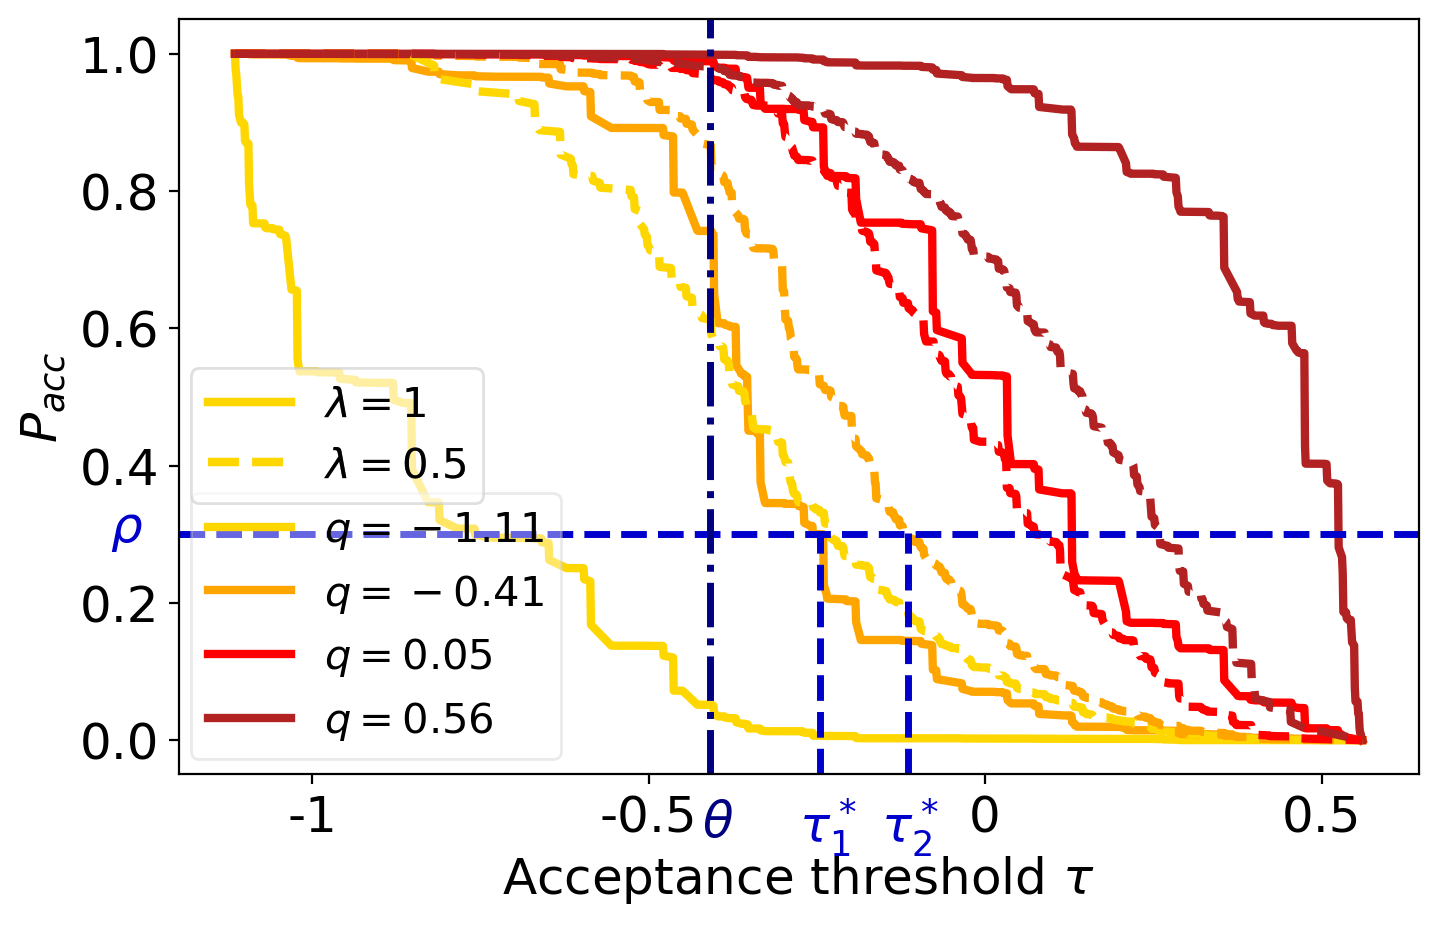

In [78]:
plt.figure(figsize=(8,5), dpi= 200)
Color_list = ['gold','orange','red','firebrick']

L = 4 # The number of categories
m = 3 # The number of solicited reviews

# Compute and plot the acceptance probability of papers of difference categories versus the acceptance threshold
# lambda = 1: the best review quality that can be achieved
lam = 1
tau_range = np.arange(min(Q),max(Q), 0.001)
P_acc = []
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
for tau in tau_range:
    P_acc.append(P_acc_multi(tau, m, Gamma_w))
q1, = plt.plot(tau_range, np.array(P_acc)[:,0], linewidth = 3, c = Color_list[0])
q2, = plt.plot(tau_range, np.array(P_acc)[:,1], linewidth = 3, c = Color_list[1])
q3, = plt.plot(tau_range, np.array(P_acc)[:,2], linewidth = 3, c = Color_list[2])
q4, = plt.plot(tau_range, np.array(P_acc)[:,3], linewidth = 3, c = Color_list[3])
    
# lambda = 0.5: convex combination of the best Gamma and the uniform Gamma with weight 0.5
lam = 0.5
P_acc = []
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
P_acc_multi(np.array(0),m, Gamma_w)
for tau in tau_range:
    P_acc.append(P_acc_multi(tau, m, Gamma_w))
for i in range(L):
    if i == 0:
        q1_worse, = plt.plot(tau_range, np.array(P_acc)[:,i], linewidth = 3, c = Color_list[i], linestyle = '--')
    else:
        plt.plot(tau_range, np.array(P_acc)[:,i], linewidth = 3, c = Color_list[i], linestyle = '--')

        
legend1 = plt.legend([q1,q2,q3,q4], [r'$q=-1.11$',r'$q=-0.41$',r'$q=0.05$',r'$q=0.56$'], fontsize=15, loc = (0.01,0.02),framealpha = 0.4)
legend2 = plt.legend([q1,q1_worse], [r'$\lambda=1$',r'$\lambda=0.5$'], fontsize=15, loc = (0.01,0.36),framealpha = 0.4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel(r'Acceptance threshold $\tau$', fontsize=18)
plt.ylabel(r'$P_{acc}$', fontsize=18)
plt.tick_params(labelsize=18)

plt.axhline(y=0.3, color='mediumblue', linestyle='--', linewidth = 2.5)
plt.axvline(x=-0.408, color='navy', linestyle='-.', linewidth = 2.5)
plt.axvline(x=-0.245, color='mediumblue', linestyle='--', linewidth = 2.5, ymin = 0, ymax = 0.32)
plt.axvline(x=-0.115, color='mediumblue', linestyle='--', linewidth = 2.5, ymin = 0, ymax = 0.32)
plt.text(-0.277,-0.15,r'$\tau^*_1$', fontsize=18, color='mediumblue')
plt.text(-0.155,-0.15,r'$\tau^*_2$', fontsize=18, color='mediumblue')
plt.text(-0.42,-0.14,r'$\theta$', fontsize=18, color='navy')
plt.text(-1.3,0.29,r'$\rho$', fontsize=18, color='mediumblue')

plt.xticks([-1, -0.5,0,0.5], ['-1','-0.5','0','0.5'])

## 2.3. The QB-tradeoff

Text(-1.65, 0.01, 'Accept nothing')

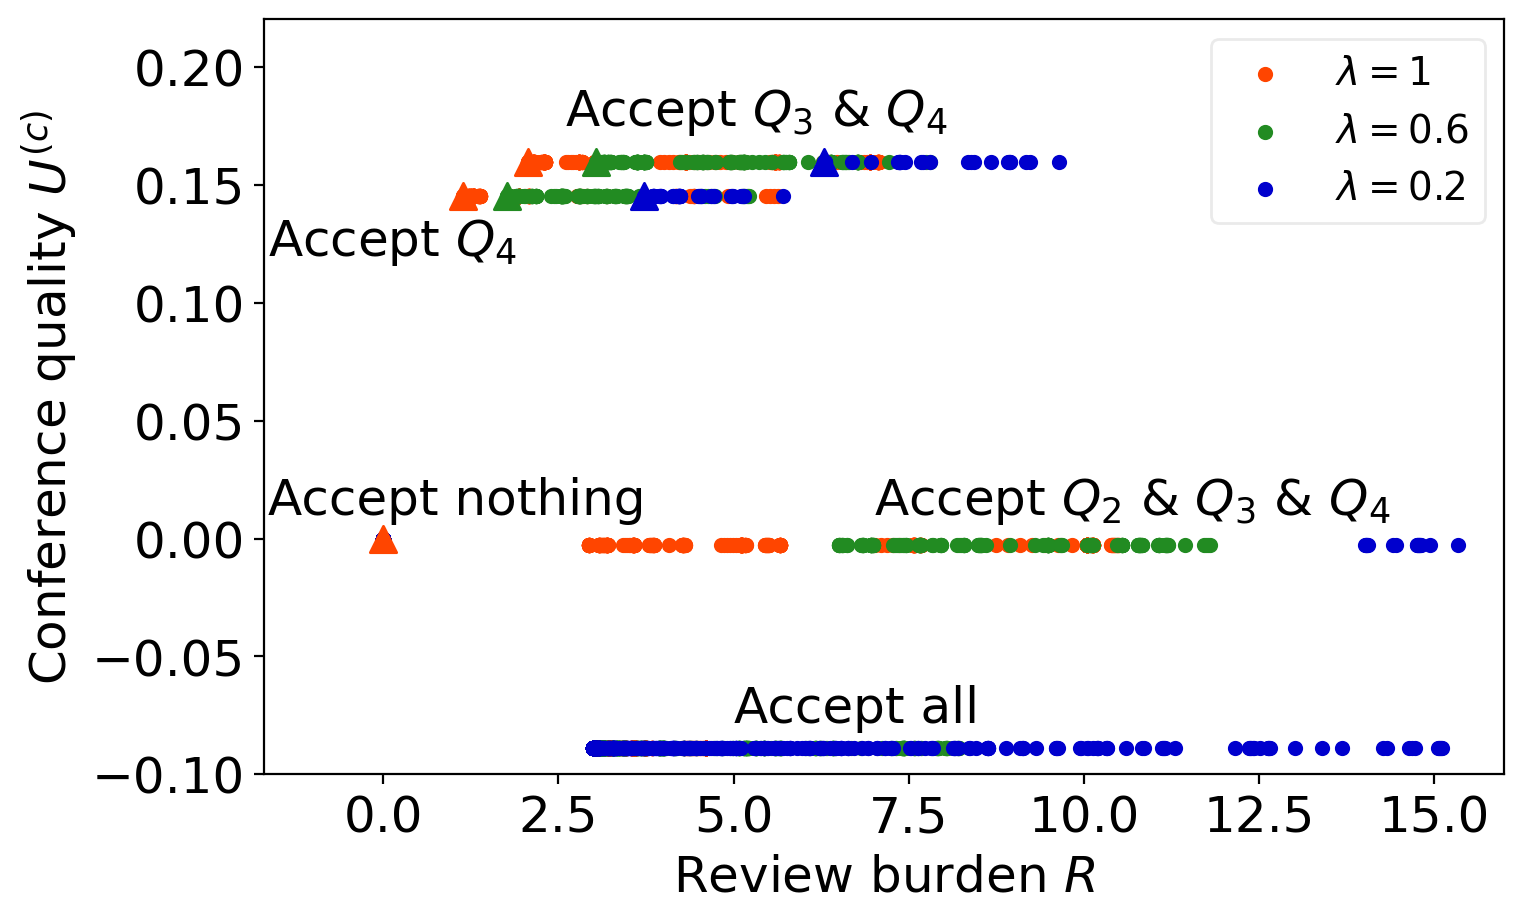

In [81]:
plt.figure(figsize=(8,5), dpi= 200)
tau_range = np.arange(min(Q),max(Q), 0.001)

L = 4 # The number of categories
m = 3 # The number of solicited reviews
V = 3 # conference value
eta = 0.7 # discount factor
rho = (1-eta)/(V-eta)

# lambda = 1
lam = 1
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
U_c = [] # conference quality
R = [] # review burden

for tau in tau_range:
    P_acc = P_acc_multi(tau,m, Gamma_w)
    index = np.where(P_acc >= rho)[0] # the categories of paper that will be submitted
    U_c.append(np.sum((w*Q)[index])) # the conference quality: the expected quality of the submitted (and accepted) papers
    R.append(m*np.sum((w/P_acc)[index])) # the review burden: the expected number of reviews for each paper
plt.scatter(R, U_c, c = 'orangered', s = 20, label = r'$\lambda=1$')
Uc_po, R_po, index = Pareto_optimal(U_c, R)
plt.scatter(R_po, Uc_po, c = 'orangered', s = 90, marker = '^')


# lambda = 0.6
lam = 0.6
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
U_c = []
R = []

for tau in tau_range:
    P_acc = P_acc_multi(tau, m, Gamma_w)
    index = np.where(P_acc >= rho)[0]
    U_c.append(np.sum((w*Q)[index]))
    R.append(m*np.sum((w/P_acc)[index]))
plt.scatter(R, U_c, c = 'forestgreen', s = 20, label = r'$\lambda=0.6$')
Uc_po, R_po, index = Pareto_optimal(U_c, R)
plt.scatter(R_po, Uc_po, c = 'forestgreen', s = 90, marker = '^')


# lambda = 0.2
lam = 0.2
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
U_c = []
R = []

for tau in tau_range:
    P_acc = P_acc_multi(tau, m, Gamma_w)
    index = np.where(P_acc >= rho)[0]
    U_c.append(np.sum((w*Q)[index]))
    R.append(m*np.sum((w/P_acc)[index]))
plt.scatter(R, U_c, c = 'mediumblue', s = 20, label = r'$\lambda=0.2$')
Uc_po, R_po, index = Pareto_optimal(U_c, R)
plt.scatter(R_po, Uc_po, c = 'mediumblue', s = 90, marker = '^')
plt.scatter(0, 0, c = 'orangered', s = 90, marker = '^')

plt.legend(fontsize=14, framealpha = 0.4)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.tick_params(labelsize=18)
plt.ylim(-0.1,0.22)
plt.xlim(-1.7,16)

plt.text(2.6,0.175,r'Accept $Q_3$ & $Q_4$', fontsize=18, color='black')
plt.text(-1.65,0.12,r'Accept $Q_4$', fontsize=18, color='black')
plt.text(7,0.01,r'Accept $Q_2$ & $Q_3$ & $Q_4$', fontsize=18, color='black')
plt.text(5,-0.078,r'Accept all', fontsize=18, color='black')
plt.text(-1.65,0.01,r'Accept nothing', fontsize=18, color='black')

## 2.4. Acceptance Rate

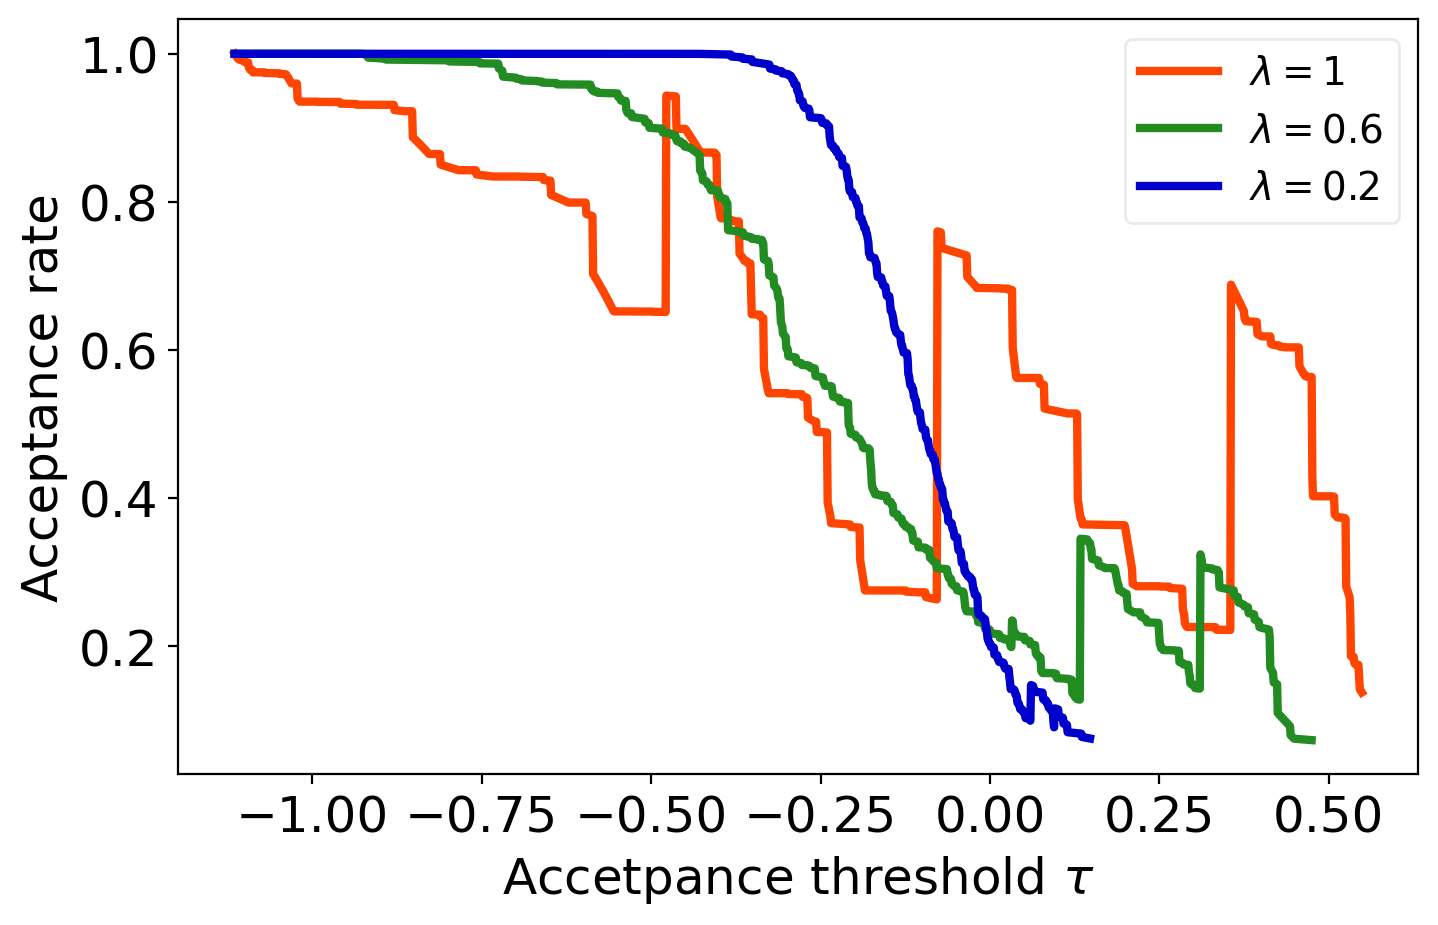

In [83]:
plt.figure(figsize=(8,5), dpi= 200)
tau_range = np.arange(min(Q),max(Q), 0.001)

L = 4 # The number of categories
m = 3 # The number of solicited reviews
V = 3 # conference value
eta = 0.7 # discount factor
rho = (1-eta)/(V-eta)

# lambda = 1
lam = 1
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
Acc_rate = []

for tau in tau_range:
    P_acc = P_acc_multi(tau, m, Gamma_w)
    index = np.where(P_acc >= rho)[0]
    Acc_rate.append(np.sum(w[index])/np.sum((w/P_acc)[index]))
plt.plot(tau_range, Acc_rate, c = 'orangered', linewidth = 3, label = r'$\lambda=1$')


# lambda = 0.6
lam = 0.6
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
V = 5
eta = 0.7
rho = (1-eta)/(V-eta)
Acc_rate = []

for tau in tau_range:
    P_acc = P_acc_multi(tau, m, Gamma_w)
    index = np.where(P_acc >= rho)[0]
    Acc_rate.append(np.sum(w[index])/np.sum((w/P_acc)[index]))
plt.plot(tau_range, Acc_rate, c = 'forestgreen', linewidth = 3, label = r'$\lambda=0.6$')


# lambda = 0.2
lam = 0.2
Gamma_w = Gamma*lam+np.ones((L,10))/10*(1-lam)
Mapping_review_to_quality(Gamma_w)
V = 5
eta = 0.7
rho = (1-eta)/(V-eta)
Acc_rate = []

for tau in tau_range:
    P_acc = P_acc_multi(tau, m, Gamma_w)
    index = np.where(P_acc >= rho)[0]
    Acc_rate.append(np.sum(w[index])/np.sum((w/P_acc)[index]))
plt.plot(tau_range, Acc_rate, c = 'mediumblue', linewidth = 3, label = r'$\lambda=0.2$')

plt.legend(fontsize=14, framealpha = 0.4)
plt.xlabel(r'Accetpance threshold $\tau$', fontsize=18)
plt.ylabel(r'Acceptance rate', fontsize=18)
plt.tick_params(labelsize=18)

## 2.5. The Optimal Number of Solicited Reviews

Given a review quality (captured by $\lambda$), a number of solicited reviews (denoted as $m$) and a goal de facto threthold (captured by the number of categories of papers that are willing to submit, $j$), we can compute an optimal acceptance threshold $\tau$ such that the review burden is minimized while guaranteeing such a de facto threshold. This minimum review burden is plotted for different $\lambda$ and $m$. (One can also change the third dimension, $j$.)

In [141]:
"""
Review burden vs lambda for different m
------------------
This takes about 5 min to run
"""
L = 4 # The number of categories
V = 5 # conference value
eta = 0.7 # discount factor
rho = (1-eta)/(V-eta)
lam_range = np.arange(0.2,1,0.01)

R = np.zeros((len(lam_range),5,3)) # Review burden with the first dimension the review quality;
                                   # the second dimension the number of reviews (from 1 to 5);
                                   # the third dimension the number of categories of papers that will be submitted.

for i,lam in enumerate(lam_range):
    Gamma_w = Gamma*lam + np.ones((L,10))/10*(1-lam)
    Mapping_review_to_quality(Gamma_w)
    for m in range(1,6):
        for j in range(1,4):
            
            # We use a binary search to find the optimal acceptance threshold
            low = min(G_mean)
            high = max(G_mean)
            while high-low > 0.0005:
                mid = (high + low)/2
                P_acc = P_acc_multi(mid,m,Gamma_w)
                n_submit = np.count_nonzero(P_acc >= rho) # the number of categories of papers that will be submitted
                if n_submit <= j: # if the de facto threshold too low, we should try lower acceptnce threshold
                    high = mid
                else:
                    low = mid
            tau = high # the threshold "high" guarantees the goal de facto threshold
            P_acc = P_acc_multi(tau, m, Gamma_w)
            R[i,m-1,j-1] = m*np.sum(w[L-j:]/P_acc[L-j:])

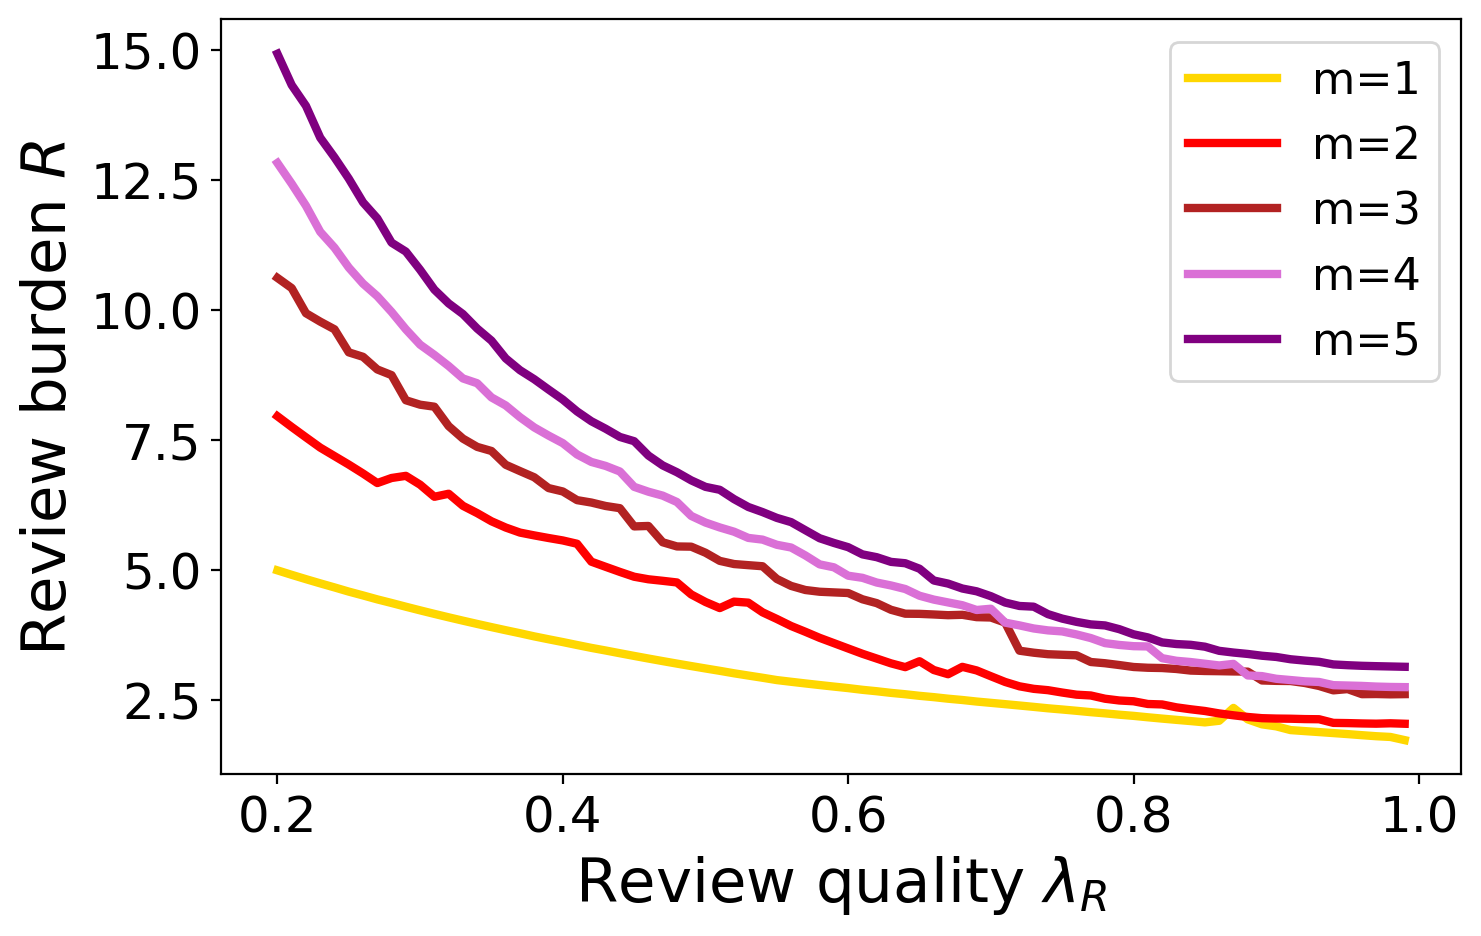

In [121]:
plt.figure(figsize=(8,5), dpi= 200)
Colors = ['gold','red','firebrick','orchid','purple']
Lines = ['-','--','-.']

j = 2 # we plot the case where the de facto threshold maximizes the conference quality (the top 2 categories will submit)
for m in range(1,6):
    plt.plot(lam_range, R[:,m-1,j-1],color = Colors[m-1],linewidth=3,label = 'm='+str(m))
plt.legend(fontsize=16)
plt.xlabel(r'Review quality $\lambda_R$', fontsize=22)
plt.ylabel(r'Review burden $R$', fontsize=22)
plt.tick_params(labelsize=18)

In [142]:
"""
In addition to the previous figure, we further vary the conference value, V.
Again, the de facto threshold is fixed at the one that only the top two categories will submit.
This takes hours to run, but the results are saved.
"""

L = 4 # The number of categories
V = 5 # conference value
eta = 0.7 # discount factor
rho = (1-eta)/(V-eta)
V_range = np.arange(1.1,30,0.025)
lam_range = np.arange(0.2,1,0.005)

opt_m = np.zeros((len(V_range),len(lam_range))) # the optimal number of solicited reviews
opt_R = np.zeros((len(V_range),len(lam_range))) # the minimum review burden

for j,lam in enumerate(lam_range):
#     if j%5 == 0:
#         print(lam, datetime.datetime.now())
    Gamma_w = Gamma*lam + np.ones((L,10))/10*(1-lam)
    Mapping_review_to_quality(Gamma_w)
    for i,V in enumerate(V_range):
        rho = (1-eta)/(V-eta)
        R = [] # the minimum review burden for each of the m
        for m in range(1,6):
            low = min(G_mean)
            high = max(G_mean)
            while high-low > 0.0005:
                mid = (high + low)/2
                P_acc = P_acc_multi(mid,m,Gamma_w)
                n_submit = np.count_nonzero(P_acc >= rho)
                if n_submit <= 2:
                    high = mid
                else:
                    low = mid
            tau = high
            P_acc = P_acc_multi(tau,m,Gamma_w)
            R.append(m*np.sum(w[2:]/P_acc[2:]))
        
        index = int(np.argmin(R)) 
        opt_m[-i-1,j] = index + 1
        opt_R[-i-1,j] = R[index]
        
# np.save('Results/Heatmap_20_L4/V_opt_m.npy',opt_m)
# np.save('Results/Heatmap_20_L4/V_opt_R.npy',opt_R)

Text(41.44444444444443, 0.5, 'Conference value $V$')

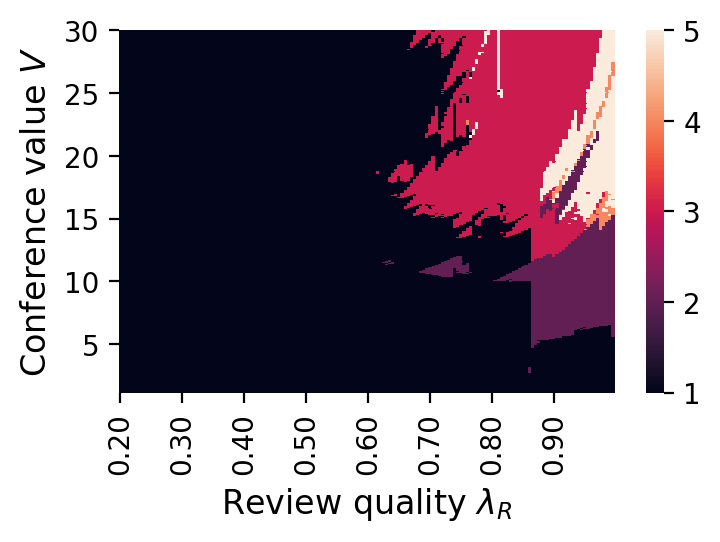

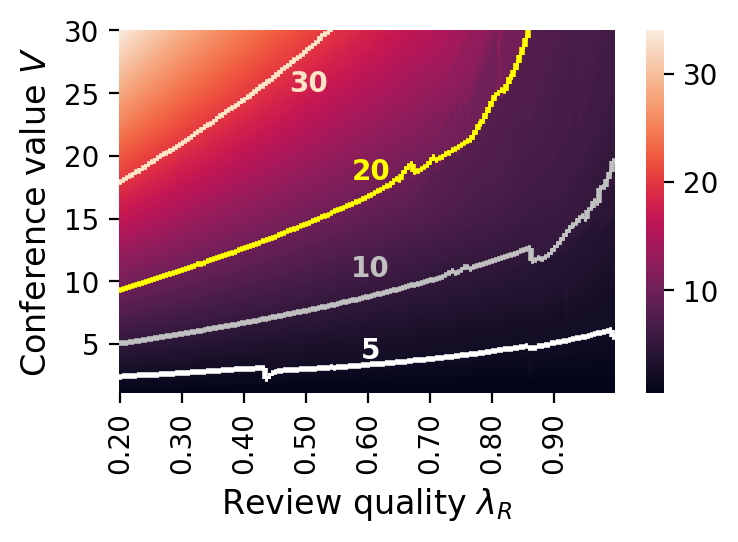

In [118]:
"""
Effect of conference value
Solve for the optimal number of solicited reviews under different eta and beta.
An m is optimal if it leads to the minimum review burden while guaranteeing the optimal conference quality.
"""

opt_m = np.load('Results/Heatmap_20_L4/V_opt_m.npy')
opt_R = np.load('Results/Heatmap_20_L4/V_opt_R.npy')

def add_iso_line(fig, value, color):
    """
    Input: "fig" is the figure to plot contours;
           "value" is the value of the contour;
           "color" indicates the name of the color of the contour.
    The function will draw the countour on the input figure
    """
    v = df.gt(value).diff(axis=1).fillna(False).to_numpy()
    h = df.gt(value).diff(axis=0).fillna(False).to_numpy()

    l = np.argwhere(v.T)    
    vlines = np.array(list(zip(l, np.stack((l[:,0], l[:,1]+1)).T)))

    l = np.argwhere(h.T)    
    hlines = np.array(list(zip(l, np.stack((l[:,0]+1, l[:,1])).T)))

    lines = np.vstack((vlines, hlines))
    fig.add_collection(LineCollection(lines, lw=2, colors=color ))
        
        
        
# The optimal number of solicited reviews
df = pd.DataFrame(opt_m, index=list(np.flip(V_range)) ,columns=list(lam_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=20,yticklabels=200,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\lambda_R$',fontsize = 12)
plt.ylabel(r'Conference value $V$',fontsize = 12)



# The minimum review burden 
df = pd.DataFrame(opt_R, index=list(np.flip(V_range)) ,columns=list(lam_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=20,yticklabels=200,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
    
# Plot contours
add_iso_line(fig, 2, 'white')
add_iso_line(fig, 5, 'silver')
add_iso_line(fig, 10, 'yellow')
add_iso_line(fig, 20, 'bisque')

plt.text(78, 1020, '5', va='center',color = 'white',weight='bold',fontsize = 10)
plt.text(75, 760, '10', va='center',color = 'silver',weight='bold',fontsize = 10)
plt.text(75, 450, '20', va='center',color = 'yellow',weight='bold',fontsize = 10)
plt.text(55, 170, '30', va='center',color = 'bisque',weight='bold',fontsize = 10)

fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\lambda_R$',fontsize = 12)
plt.ylabel(r'Conference value $V$',fontsize = 12)


## 2.6. The T-round Fixed Threshold Policy

In [140]:
colors = ['gold','orange','orangered','firebrick','darkred']
Line = ['-','--','-.']
L = 4 # The number of categories
V = 5 # conference value
eta = 0.7 # discount factor
rho = (1-eta)/(V-eta)
tau_range = np.arange(min(Q),max(Q), 0.001)

Gamma_w = Gamma # fix the review quality to the best confusion matrix
Mapping_review_to_quality(Gamma_w)

PO_4_all = [] # the Pareto optimal points for every m when the de facto threshold is only the best category submitting
PO_34_all = [] # the Pareto optimal points for every m when the de facto threshold is the top 2 categories submitting
for m in [1,5]:
    PO_4 = [[0,0,4]] # Fixing an m, the Pareto optimal points when only the top category submits;
                     # the first two entries are review burden and conference quality, respectively;
                     # the third dimension indicates different T: 0 to 3 correspond to T = 1 to 4, respectively, and 4 indicates T = infty.
    PO_34 = [[0,0,4]] # fixing an m, the Pareto optimal points when the top 2 categories submit.
    
    # For every T in {1,2,3,4}
    for h,T in enumerate([1,2,3,4]):
        U_c = []
        R = []
        submitted = [] # the number of categories that are submitted
        for tau in tau_range: # search the acceptane threshold and find the Pareto optimal points
            P_acc = P_acc_multi(tau, m, Gamma_w)
            index = np.where(P_acc >= rho)[0]
            submitted.append(len(index))
            U_c.append(np.sum((w*Q*(1-np.power(1-P_acc,T)))[index]))
            R.append(m*np.sum((w*(1-np.power(1-P_acc,T))/P_acc)[index]))
        U_po,R_po,index_po = Pareto_optimal(U_c,R)
        for i in range(len(index_po)):
            if submitted[index_po[i]] == 1:
                PO_4.append([R[index_po[i]], U_c[index_po[i]],h])
            elif submitted[index_po[i]] == 2:
                PO_34.append([R[index_po[i]], U_c[index_po[i]],h])

    # For T = infty
    U_c = []
    R = []
    submitted = []
    h = 4
    for tau in tau_range:
        P_acc = P_acc_multi(tau, m, Gamma_w)
        index = np.where(P_acc >= rho)[0]
        submitted.append(len(index))
        U_c.append(np.sum((w*Q)[index]))
        R.append(m*np.sum((w/P_acc)[index]))
    U_po,R_po,index_po = Pareto_optimal(U_c,R)
    for i in range(len(index_po)):
        if submitted[index_po[i]] == 1:
            PO_4.append([R[index_po[i]], U_c[index_po[i]],h])
        elif submitted[index_po[i]] == 2:
            PO_34.append([R[index_po[i]], U_c[index_po[i]],h])

    PO_34 = np.array(PO_34)
    PO_4 = np.array(PO_4)
    PO_34_all.append(PO_34)
    PO_4_all.append(PO_4)
    


Text(-0.35, 0.16, 'MAX')

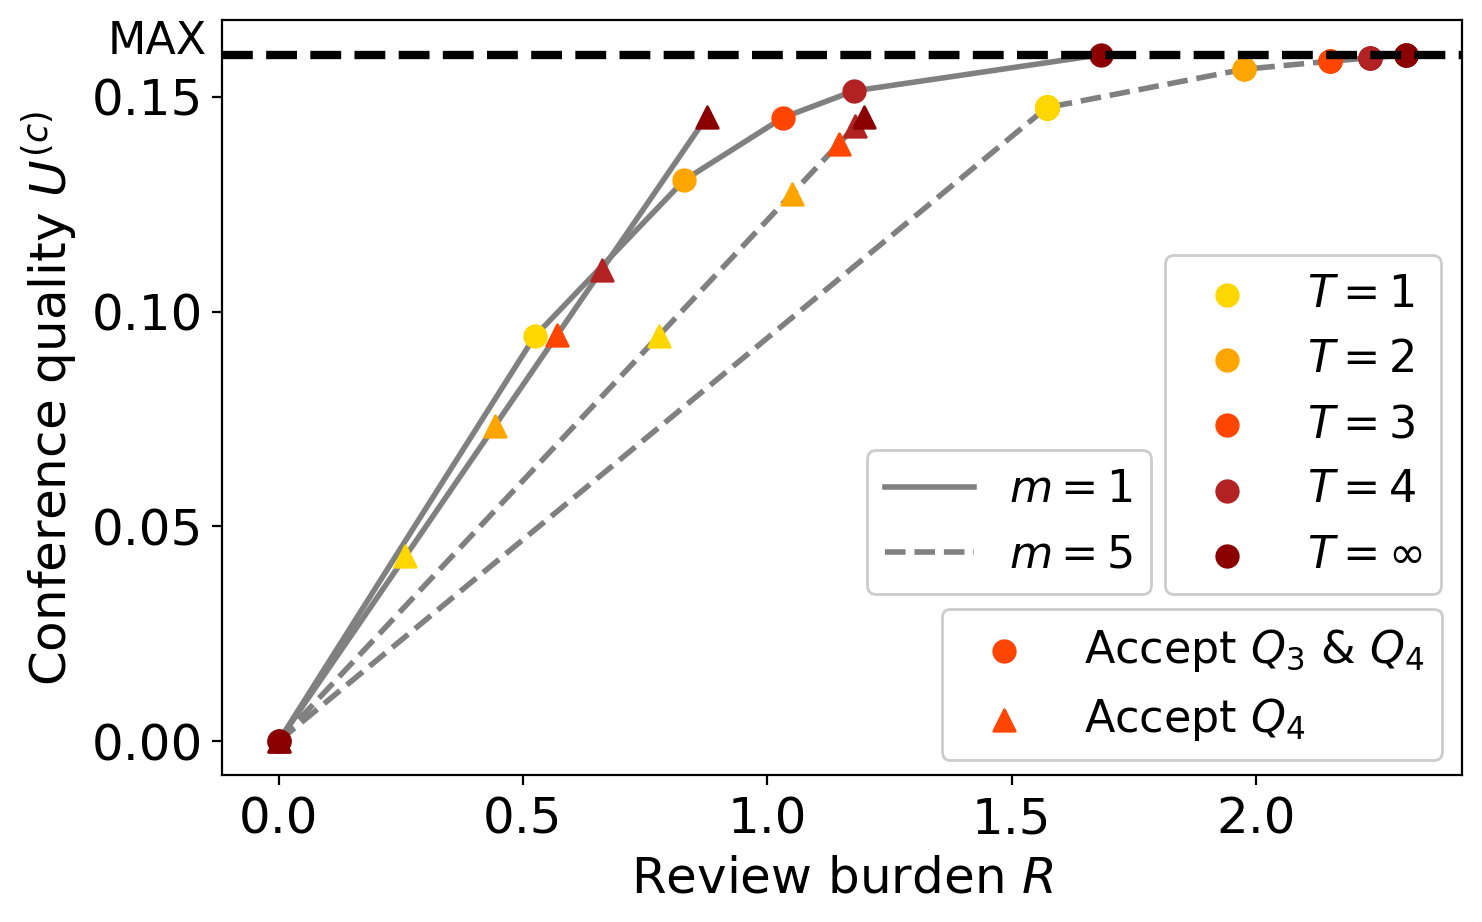

In [139]:
plt.figure(figsize=(8,5), dpi= 200)
for m in [1,5]: 
    PO_34 = PO_34_all[int((m-1)/4)]
    PO_4 = PO_4_all[int((m-1)/4)]
    if m == 1:
        M1 ,= plt.plot(PO_34[:,0], PO_34[:,1], c = 'grey', linewidth=2, linestyle=Line[int((m-1)/4)], label = r'$Q_3 & Q_4$',zorder=1)
    elif m == 5:
        M5 ,= plt.plot(PO_34[:,0], PO_34[:,1], c = 'grey', linewidth=2, linestyle=Line[int((m-1)/4)], label = r'$Q_3 & Q_4$',zorder=1)
    plt.plot(PO_4[:,0], PO_4[:,1], c = 'grey', linewidth=2, linestyle=Line[int((m-1)/4)], label = r'$Q_4$',zorder=1)
    for i in range(np.size(PO_34, axis = 0)):
        if m == 1 and int(PO_34[i,2]) == 0:
            T_1 = plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
        elif m == 1 and int(PO_34[i,2]) == 1:
            T_2 = plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
        elif m == 1 and int(PO_34[i,2]) == 2:
            T_3 = plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
        elif m == 1 and int(PO_34[i,2]) == 3:
            T_4 = plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
        elif m == 1 and int(PO_34[i,2]) == 4:
            T_inf = plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
        else:
            plt.scatter(PO_34[i,0], PO_34[i,1], marker = 'o', s= 60, color = colors[int(PO_34[i,2])],zorder=2)
    for i in range(np.size(PO_4, axis = 0)):
        if m == 1 and int(PO_4[i,2]) == 2:
            ACC_Q_4 = plt.scatter(PO_4[i,0], PO_4[i,1], marker = '^', s = 60, color = colors[int(PO_4[i,2])],zorder=2)
        else:
            plt.scatter(PO_4[i,0], PO_4[i,1], marker = '^', s = 60, color = colors[int(PO_4[i,2])],zorder=2)

legend1 = plt.legend([T_1,T_2,T_3,T_4,T_inf], [r'$T=1$',r'$T=2$',r'$T=3$',r'$T=4$',r'$T=\infty$'], fontsize=16, loc = (0.76,0.24),framealpha = 1)
legend2 = plt.legend([T_3,ACC_Q_4], [r'Accept $Q_3$ & $Q_4$',r'Accept $Q_4$'], fontsize=16, loc = (0.58,0.02),framealpha = 1)
legend3 = plt.legend([M1,M5], [r'$m=1$',r'$m=5$'], fontsize=16, loc = (0.52,0.24),framealpha = 1)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.tick_params(labelsize=18)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.axhline(y=sum(w[2:]*Q[2:]), color='black', linestyle='--', linewidth = 3)
plt.text(-0.35,0.16,'MAX', fontsize=16, color='black')

# 3. Noisy Authors

Results in this section are solved with our agent-based model. For short, we call the authors Alice and the conference Bob.

Because the optimal strategy of the author is very time-consuming, we only consider the myopic strategy of the authors in our experiments.

## 3.1. Agent based model setup

In [179]:
n = 5000 # the number of new papers each round
L = 4 # the number of categories
# w is the prior distribution of the paper quality
Gamma_A = Gamma # the confusion matrix of authors
Gamma_B = Gamma # the confusion matrix of the conference (Bob)
Q_index = [i for i in range(L)] # the indexes of the categories
# Q is the set of values of paper qualities
signal_space = [i for i in range(10)] # the set of signals
V = 5 # the conference value
eta = 0.7 # the discount factor
T = 10 # the number of rounds of total submission
m = 3 # the number of solicited reviews

# Row of Alices: [0: quality, 1: signal, 2: B, 3: value, 4: eta]
def initialization():
    global quality, S, papers, reviews_his, utility
    quality = np.array(random.choices(Q_index, w, k = n)) # the indexes of the ground truth quality of the papers
    S = np.zeros(n) # the signal of each author
    for l in range(L):
        S[np.where(quality == l)[0]] = np.array(random.choices(signal_space, Gamma_A[l], k = len(np.where(quality == l)[0])))
    
    papers = np.zeros(n) # The status of papers, with 0 to be submitted, 1 submitted, 2 accepted and 3 submitted to low conference
    reviews_his = [[] for i in range(n)] # The review history of each paper, recording the number of different reviews at each round
    utility= np.zeros(n) # The eventually utility of each paper


def update():
    Alice_strategy_myopic()
    Bob_strategy_memoryless_hardthreshold(tau)
        
        
        
############## Author (Alice)    

def Alice_strategy_myopic():
    """
    The function will update the status of each paper by deciding whether it will be submitted to Bob in the next 
    round, given the authors' best response mapping.
    """
    for i in np.where(papers == 0)[0]: # for every paper that has not been accepted by either Bob or the sure bet option
        review_counts = np.sum(np.array(reviews_his[i]), axis = 0) # count the historical reviews
        if reviews_his[i] == []: # if the paper has not been submitted
            review_counts = np.zeros(10)
        else:
            review_counts = np.sum(np.array(reviews_his[i]), axis = 0)

        conditional_A = np.ones(L)
        conditional_B = np.ones(L)
        for l in range(L):
            conditional_A[l] = Gamma_A[l,int(S[i])]
            for s in range(10):
                conditional_B[l] *= np.power(Gamma_B[l,s], review_counts[s])
        P_quality = (w*conditional_A*conditional_B)/np.sum(w*conditional_A*conditional_B) # the posterior distribution of paper quality conditional of the author's signal and historical reviews
        
        # if there exists a review signal such that conditional on it, the expected quality of the paper is higher than the threshold
        if len(np.where(Review_to_quality >= tau)[0]) != 0:
            index = np.where(Review_to_quality >= tau)[0][0]
            # if the threshold is very low such that all review signals imply acceptance
            if index == 0:
                P_acc = 1
            # intermediate cases
            else:
                P_acc = np.sum(P_quality*(np.sum(Review_to_probability[index:], axis = 0) + (Review_to_quality[index] - tau)/(Review_to_quality[index]-Review_to_quality[index-1])*Review_to_probability[index-1]))
        
        # if the threshold is very high such that no review signal can guarantee acceptance
        else:
            P_acc = np.sum(P_quality*(Review_to_probability[-1]*(max(Q)-tau)/(max(Q)-Review_to_quality_1[-1])))
    
        times = len(reviews_his[i]) # the number of times the paper has been submitted
        U_submit = P_acc*V*np.power(eta, times) + (1-P_acc)*np.power(eta, times+1)
        if U_submit >= np.power(eta, times): # if it's better to submit the paper to the high conference
            papers[i] = 1
        else: # if it's better to submit to the sure bet
            papers[i] = 3
            utility[i] += np.power(eta, times)

                
def Bob_strategy_memoryless_hardthreshold(tau): # Bob accepts the paper with k new indep. draws and average score larger or equal tau
    """
    This function draws iid reviews for a new round and makes the accept/reject decision based on the conference policy.
    Papers' status and conference's review history and acceptance history are then updated.
    """
    for i in np.where(papers == 1)[0]:
        review = random.choices(signal_space, Gamma_B[quality[i]], k = m)
        count = [len(np.where(np.array(review) == signal_space[i])[0]) for i in range(10)]
        score = Review_to_quality_dic[tuple(count)]
        
        # if the expected score is larger than tau, accept
        if score >= tau: 
            papers[i] = 2
            times = len(reviews_his[i])
            utility[i] += V*np.power(eta, times)
        else:
            # compute score_h
            if score == Review_to_quality[-1]: 
                score_h = max(Q)
            else:
                index = np.where(Review_to_quality == score)[0][0]
                score_h = Review_to_quality[index+1]
            
            # if score_h is smaller than tau, reject
            if score_h < tau:
                papers[i] = 0
            # if score_h is larger than tau, accept with probability
            else:
                random_seed = random.uniform(0, 1)
                if random_seed <= (score_h-tau)/(score_h-score):
                    papers[i] = 2
                    times = len(reviews_his[i])
                    utility[i] += V*np.power(eta, times)
                else:
                    papers[i] = 0
        reviews_his[i].append(count)

    


In [218]:
"""
Compute the review-quality mapping
"""

def Mapping_review_to_quality_noisy(Gamma, m):
    """
    Input: "Gamma" is the confusion matrix;
           "m" is the number of solicited reviews.
    For each m = 1, ..., 5, the function computes 
    1) an array of all the possible posterior qualities of the paper; 
    2) an array of the probabilities of the occurrence of each of the set of review signals;
    3) the mapping from the reviews to the values of posterior quality;
    """
    global Review_to_quality, Review_to_probability, Review_to_quality_dic
    
    if m == 1:
        Review_to_quality = [] # an array of the possible values of posterior paper quality conditional on the reviews
        Review_to_probability = [] # an array of the probability of the occurrence of each set of review signals
        Review_to_quality_dic = {} # a dictionary that maps from the reviews to the values of expected paper quality
        for r1 in range(10):
            exp = np.sum((w*Gamma[:,r1]/np.sum(w*Gamma[:,r1]))*Q) # the posterior quality conditional on the reviews
            Review_to_quality.append(exp)
            Review_to_probability.append(Gamma[:,r1])
            review_distribution = tuple(np.bincount([r1], weights=None, minlength=10))
            Review_to_quality_dic[review_distribution] = exp
        # sort the lists
        Review_to_probability = [x for _, x in sorted(zip(Review_to_quality, Review_to_probability))]
        Review_to_quality = sorted(Review_to_quality)

    if m == 2:
        Review_to_quality = []
        Review_to_probability = []
        Review_to_quality_dic = {}
        for r1 in range(10):
            for r2 in range(10):
                exp = np.sum((w*Gamma[:,r1]*Gamma[:,r2]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]))*Q)
                Review_to_quality.append(exp)
                Review_to_probability.append(Gamma[:,r1]*Gamma[:,r2])
                review_distribution = tuple(np.bincount([r1, r2], weights=None, minlength=10))
                Review_to_quality_dic[review_distribution] = exp

        Review_to_probability = [x for _, x in sorted(zip(Review_to_quality, Review_to_probability), key = lambda x: x[0])]
        Review_to_quality = sorted(Review_to_quality)

    if m == 3:
        Review_to_quality = []
        Review_to_probability = []
        Review_to_quality_dic = {}
        for r1 in range(10):
            for r2 in range(10):
                for r3 in range(10):
                    exp = np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]))*Q)
                    Review_to_quality.append(exp)
                    Review_to_probability.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3])
                    review_distribution = tuple(np.bincount([r1, r2, r3], weights=None, minlength=10))
                    Review_to_quality_dic[review_distribution] = exp

        Review_to_probability = [x for _, x in sorted(zip(Review_to_quality, Review_to_probability), key = lambda x: x[0])]
        Review_to_quality = sorted(Review_to_quality)

    if m == 4:
        Review_to_quality = []
        Review_to_probability = []
        Review_to_quality_dic = {}
        for r1 in range(10):
            for r2 in range(10):
                for r3 in range(10):
                    for r4 in range(10):
                        exp = np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]))*Q)
                        Review_to_quality.append(exp)
                        Review_to_probability.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4])
                        review_distribution = tuple(np.bincount([r1, r2, r3, r4], weights=None, minlength=10))
                        Review_to_quality_dic[review_distribution] = exp

        Review_to_probability = [x for _, x in sorted(zip(Review_to_quality, Review_to_probability), key = lambda x: x[0])]
        Review_to_quality = sorted(Review_to_quality)

    if m == 5:
        Review_to_quality = []
        Review_to_probability = []
        Review_to_quality_dic = {}
        for r1 in range(10):
            for r2 in range(10):
                for r3 in range(10):
                    for r4 in range(10):
                        for r5 in range(10):
                            exp = np.sum((w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5]/np.sum(w*Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5]))*Q)
                            Review_to_quality.append(exp)
                            Review_to_probability.append(Gamma[:,r1]*Gamma[:,r2]*Gamma[:,r3]*Gamma[:,r4]*Gamma[:,r5])
                            review_distribution = tuple(np.bincount([r1, r2, r3, r4, r5], weights=None, minlength=10))
                            Review_to_quality_dic[review_distribution] = exp

        Review_to_probability = [x for _, x in sorted(zip(Review_to_quality, Review_to_probability), key = lambda x: x[0])]
        Review_to_quality = sorted(Review_to_quality)
    

## 3.2. Acceptance rate

In [ ]:
n = 5000
L = 4
m = 3
T = 10
V = 5
eta = 0.7
lambda_range = [0.5, 1]
tau_range = np.arange(min(Q),max(Q), 0.05)
Uc = np.zeros((2, 2, len(tau_range)))
R = np.zeros((2, 2, len(tau_range)))
Acc_Rate = np.zeros((2, 2, len(tau_range)))

for i, lam_B in enumerate(lambda_range):
    Gamma_B = lam_B*Gamma + (1-lam_B)*np.ones((L,10))/10
    Mapping_review_to_quality_noisy(Gamma_B, m)
    for l, lam_A in enumerate(lambda_range):
        Gamma_A = lam_A*Gamma + (1-lam_A)*np.ones((L,10))/10
        print(lam_A,lam_B)
        for h, tau in enumerate(tau_range):
            initialization() 
            for t in range(T):
                update()
            utility[np.where(papers==0)[0]] += np.power(eta,T) 
            papers[np.where(papers==0)[0]] = 3
            
            # conference quality
            for j in np.where(papers==2)[0]:
                Uc[l,i,h] += Q[quality[j]]/n
            
            # review burden and acceptance rate
            num_rev = np.zeros(n)
            n_submit = 0
            for j in range(n):
                num_rev[j] = len(reviews_his[j])*m
                n_submit += len(reviews_his[j])
            if n_submit != 0:
                Acc_Rate[l,i,h] = np.count_nonzero(papers == 2)/n_submit
            else:
                Acc_Rate[l,i,h] = 0
            R[l,i,h] = np.average(num_rev)
            
# np.save('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_Uc.npy', Uc)
# np.save('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_R.npy', R)
# np.save('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_Acc_rate.npy', Acc_Rate)

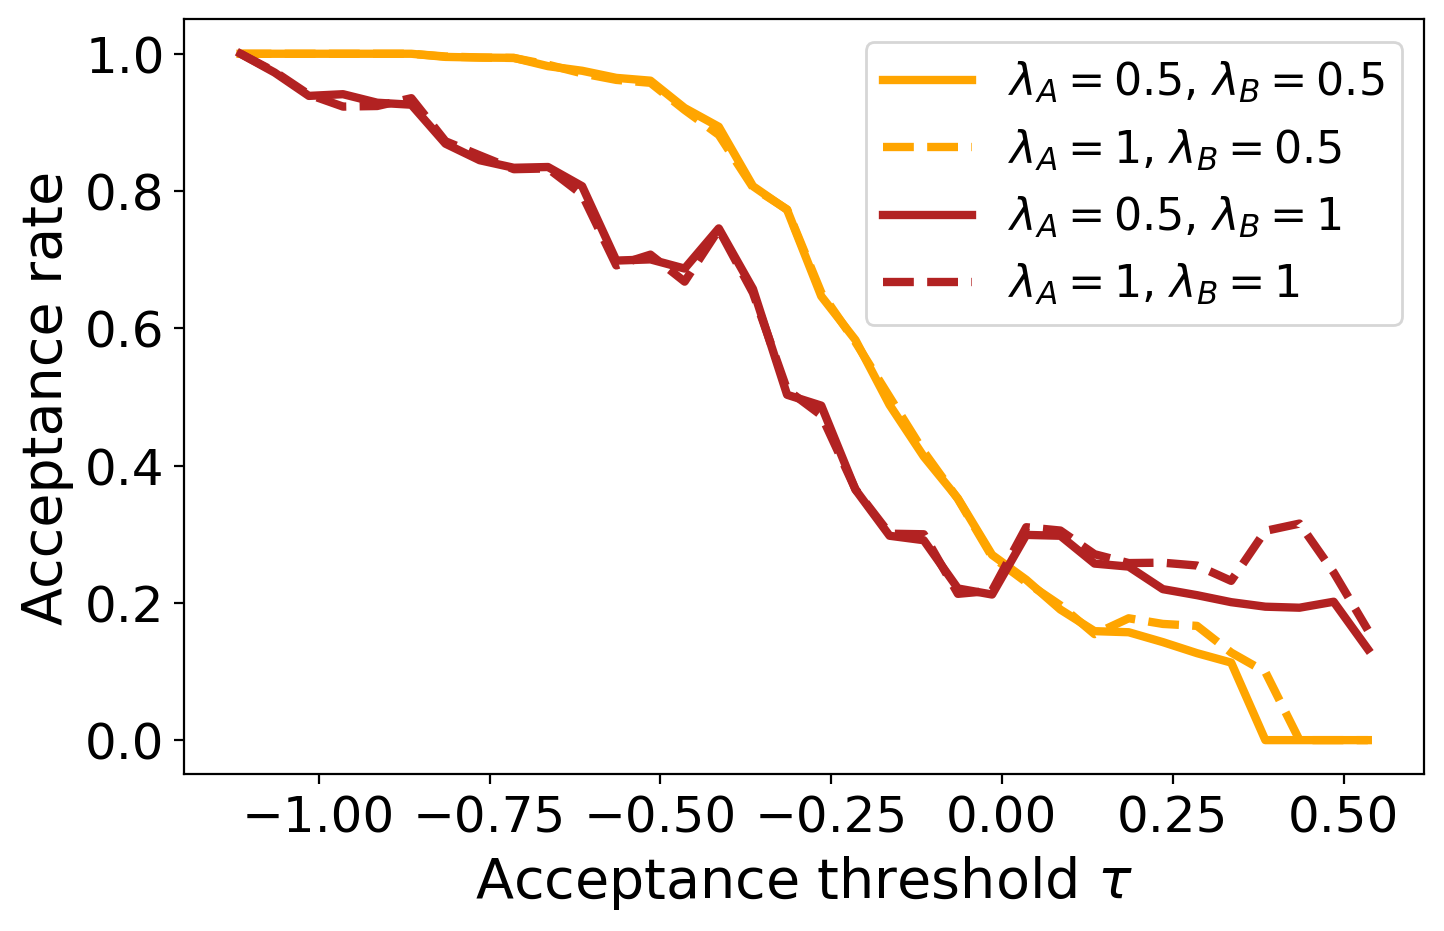

In [215]:
plt.figure(figsize=(8,5), dpi= 200)
Acc_Rate = np.load('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_Acc_rate.npy')
for i, lam in enumerate(lambda_range):
    if i == 0:
        plt.plot(tau_range, Acc_Rate[0,i], linestyle = '-', linewidth = 3, color = 'orange',  label = r'$\lambda_A=0.5$, $\lambda_B=0.5$')
    elif i == 1:
        plt.plot(tau_range, Acc_Rate[0,i],linestyle = '-', linewidth = 3, color = 'firebrick',   label = r'$\lambda_A=0.5$, $\lambda_B=1$')
    if i == 0:
        plt.plot(tau_range, Acc_Rate[1,i], linestyle = '--', linewidth = 3, color = 'orange',  label = r'$\lambda_A=1$, $\lambda_B=0.5$')
    elif i == 1:
        plt.plot(tau_range, Acc_Rate[1,i], linestyle = '--', linewidth = 3, color = 'firebrick', label = r'$\lambda_A=1$, $\lambda_B=1$')

plt.legend()
plt.xlabel(r'Acceptance threshold $\tau$', fontsize=20)
plt.ylabel(r'Acceptance rate', fontsize=20)
# plt.title(r'Myopic, ICLR 2020, $|\mathcal{Q}|=5$', fontsize=20)
plt.legend(fontsize=16)
# plt.ylim(-0.01,0.19)
# plt.axhline(y=sum(w[3:]*G_mean[3:]), color='black', linestyle='--', linewidth = 3)
plt.tick_params(labelsize=18)

## 3.3. The QB-tradeoff

In [202]:
"""
Fixing m, varying lam_A and lam_B
----------------
For noisy authors, we use the same data generated in 3.2. 
Below, we generate data for noiseless authors.
"""

rho = (1-eta)/(V-eta)
tau_range = np.arange(min(Q),max(Q), 0.05)

Uc_noiseless = np.zeros((2, len(tau_range)))
R_noiseless = np.zeros((2, len(tau_range)))
Acc_Rate_noiseless = np.zeros((2, len(tau_range)))
T = 10

for i, lam in enumerate(lambda_range):
    Gamma_B = lam*Gamma + (1-lam)*np.ones((L,10))/10
    Mapping_review_to_quality(Gamma_B)
    for h, tau in enumerate(tau_range):
        Uc_local = 0
        R_local = 0
        numerator = 0
        denominator = 0
        P_acc = P_acc_multi(tau,m,Gamma_B)
        for j in range(L):
            if P_acc[j] >= rho:
                Uc_local += w[j]*Q[j]*(1-np.power(1-P_acc[j], T))
                R_local += m*w[j]*(1-np.power(1-P_acc[j], T))/P_acc[j]
                numerator += w[j]*(1-np.power(1-P_acc[j], T))
                denominator += w[j]*(1-np.power(1-P_acc[j], T))/P_acc[j]
        Uc_noiseless[i,h] = Uc_local
        R_noiseless[i,h] = R_local
        if denominator != 0:
            Acc_Rate_noiseless[i,h] = numerator/denominator

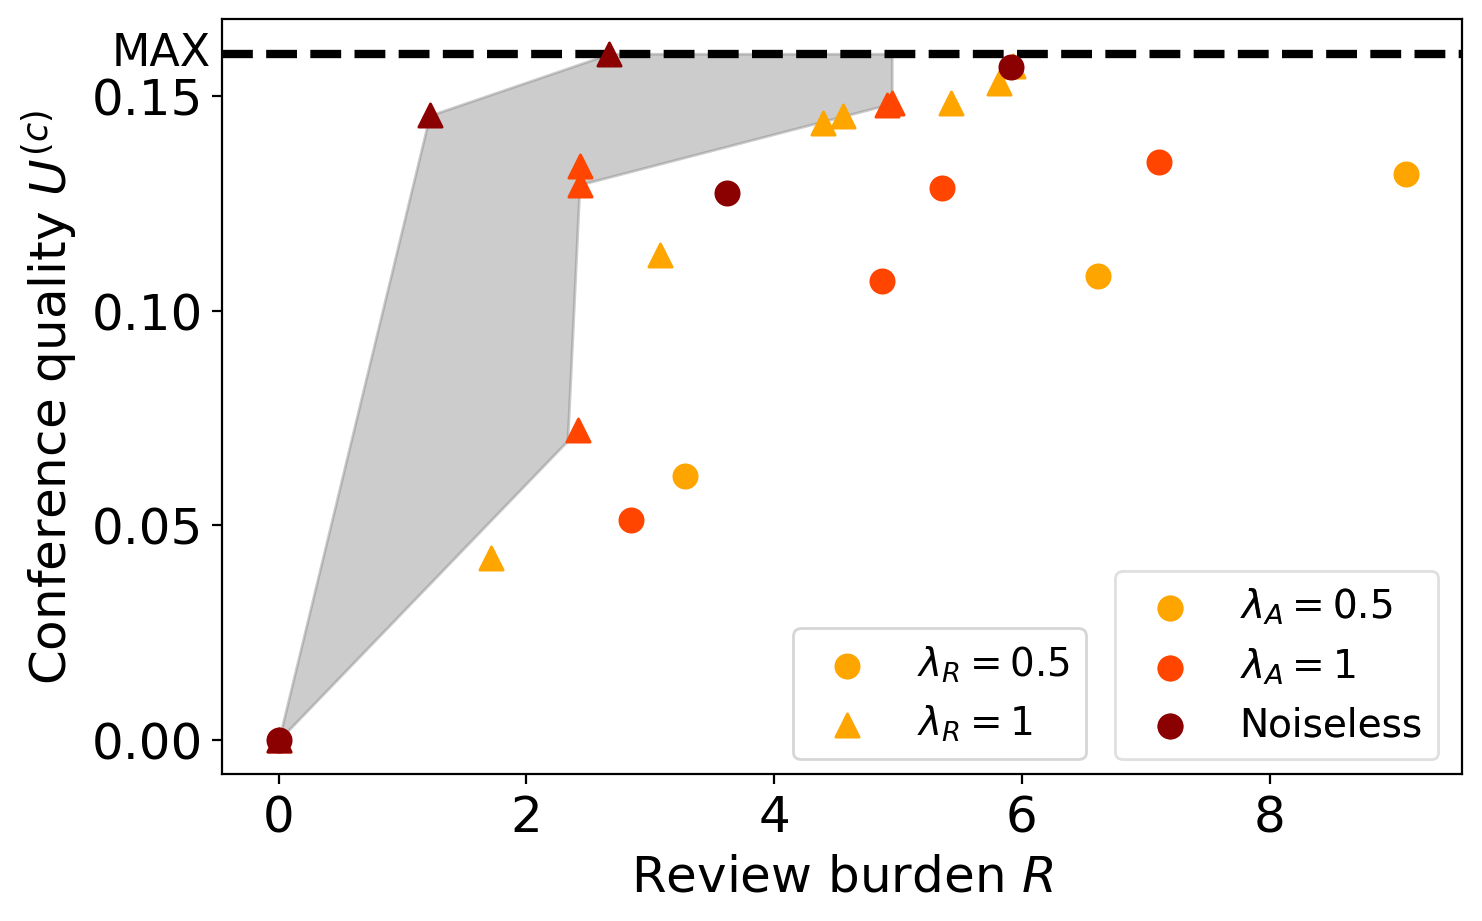

In [216]:
plt.figure(figsize=(8,5), dpi= 200)

Uc = np.load('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_Uc.npy')
R = np.load('Results/QB_tradeoff_noisy_20_L4/fixing_m_3_R.npy')

# Noisy author
for l, lam_A in enumerate(lambda_range):
    for i, lam_R in enumerate(lambda_range):
        Uc_po, R_po,index = Pareto_optimal(Uc[l,i],R[l,i])
        if l == 0 and i == 0:
            LamR_05 = plt.scatter(R_po, Uc_po, marker = 'o', color = 'orange', s=70, label = r'$\lambda_A=0.5$, $\lambda_B=0.5$')
        elif l == 0 and i == 1:
            LamR_10 = plt.scatter(R_po, Uc_po,marker = '^', color = 'orange', s=70)
        elif l == 1 and i == 0:
            LamA_10 = plt.scatter(R_po, Uc_po, marker = 'o', color = 'orangered', s=70)
        elif l == 1 and i == 1:
            X_bottom = R_po
            Y_bottom = Uc_po
            plt.scatter(R_po, Uc_po, marker = '^', color = 'orangered', s=70)

# Noiseless author
for i, lam_R in enumerate(lambda_range):
    Uc_po, R_po,_ = Pareto_optimal(Uc_noiseless[i],R_noiseless[i])
    if i == 0:
        LamA_opt = plt.scatter(R_po, Uc_po, marker = 'o', color = 'darkred', s=70)
    if i == 1:
        X_up = R_po
        Y_up = Uc_po
        plt.scatter(R_po, Uc_po, marker = '^', color = 'darkred', s=70)
            
legend1 = plt.legend([LamR_05, LamR_10], [r'$\lambda_R=0.5$', r'$\lambda_R=1$'], fontsize=14, loc = (0.46,0.02),framealpha = 0.8)
legend2 = plt.legend([LamR_05, LamA_10, LamA_opt], [r'$\lambda_A=0.5$', r'$\lambda_A=1$', 'Noiseless'], fontsize=14, loc = (0.72,0.02),framealpha = 0.4)

plt.scatter(0,0,marker = '^', color = 'orangered', s=70)
plt.scatter(0,0,marker = '^', color = 'darkred', s=70)
plt.scatter(0,0,marker = 'o', color = 'darkred', s=70)

# Draw the shaddow area
x = np.arange(0,X_bottom[0],0.01)
y_up_1 = x/X_up[1]*Y_up[1]
y_up_2 = Y_up[1]+(x-X_up[1])/(X_up[0]-X_up[1])*(Y_up[0]-Y_up[1])
y_up_3 = np.ones(len(x))*sum(w[2:]*Q[2:])
y_up = np.minimum(y_up_1,y_up_2)
y_up = np.minimum(y_up,y_up_3)

y_bottom_1 = x/X_bottom[-1]*Y_bottom[-1]
y_bottom_2 = Y_bottom[-1]+(x-X_bottom[-1])/(X_bottom[-2]-X_bottom[-1])*(Y_bottom[-2]-Y_bottom[-1])
y_bottom_3 = Y_bottom[-2]+(x-X_bottom[-2])/(X_bottom[-3]-X_bottom[-2])*(Y_bottom[-3]-Y_bottom[-2])
y_bottom_4 = Y_bottom[-3]+(x-X_bottom[-3])/(X_bottom[-4]-X_bottom[-3])*(Y_bottom[-4]-Y_bottom[-3])
y_bottom_5 = np.concatenate((np.zeros(len(np.arange(0,X_bottom[1],0.01))),Y_bottom[-4]+(np.arange(X_bottom[1],X_bottom[0],0.01)-X_bottom[-4])/(X_bottom[-5]-X_bottom[-4])*(Y_bottom[-5]-Y_bottom[-4])))
y_bottom = np.maximum(y_bottom_1,y_bottom_2)
y_bottom = np.maximum(y_bottom,y_bottom_3)
y_bottom = np.minimum(y_bottom,y_bottom_4)
y_bottom = np.maximum(y_bottom,y_bottom_5)
plt.fill_between(x, y_bottom, y_up, color='grey',alpha = 0.4,zorder=0)

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.axhline(y=sum(w[2:]*Q[2:]), color='black', linestyle='--', linewidth = 3,zorder=0)
plt.text(-1.35,0.157,'MAX', fontsize=16, color='black')
plt.tick_params(labelsize=18)

In [244]:
"""
Fixing lam_A, varying lam_B and m
------------
Results saved
"""

n = 5000
L = 4
m = 3
T = 10
V = 5
eta = 0.7
Gamma_A = Gamma
lambda_range = [0.5, 1]
tau_range = np.arange(min(Q),max(Q), 0.05)
Uc = np.zeros((2, 4, len(tau_range)))
R = np.zeros((2, 4, len(tau_range)))

for i, lam_B in enumerate(lambda_range):
    Gamma_B = lam_B*Gamma + (1-lam_B)*np.ones((L,10))/10
    for m in [1,2,3,4]:
        print(lam_B, m)
        Mapping_review_to_quality_noisy(Gamma_B, m)
        for h, tau in enumerate(tau_range):
            initialization() 
            for t in range(T):
                update()
            utility[np.where(papers==0)[0]] += np.power(eta,T) 
            papers[np.where(papers==0)[0]] = 3
            
            # conference quality
            for j in np.where(papers==2)[0]:
                Uc[i,m-1,h] += Q[quality[j]]/n
            
            # review burden
            num_rev = np.zeros(n)
            for j in range(n):
                num_rev[j] = len(reviews_his[j])*m
            R[i,m-1,h] = np.average(num_rev)
        
# np.save('Results/QB_tradeoff_noisy_20_L4/varying_m_3_Uc.npy', Uc)
# np.save('Results/QB_tradeoff_noisy_20_L4/varying_m_3_R.npy', R)

Text(-0.9, 0.157, 'MAX')

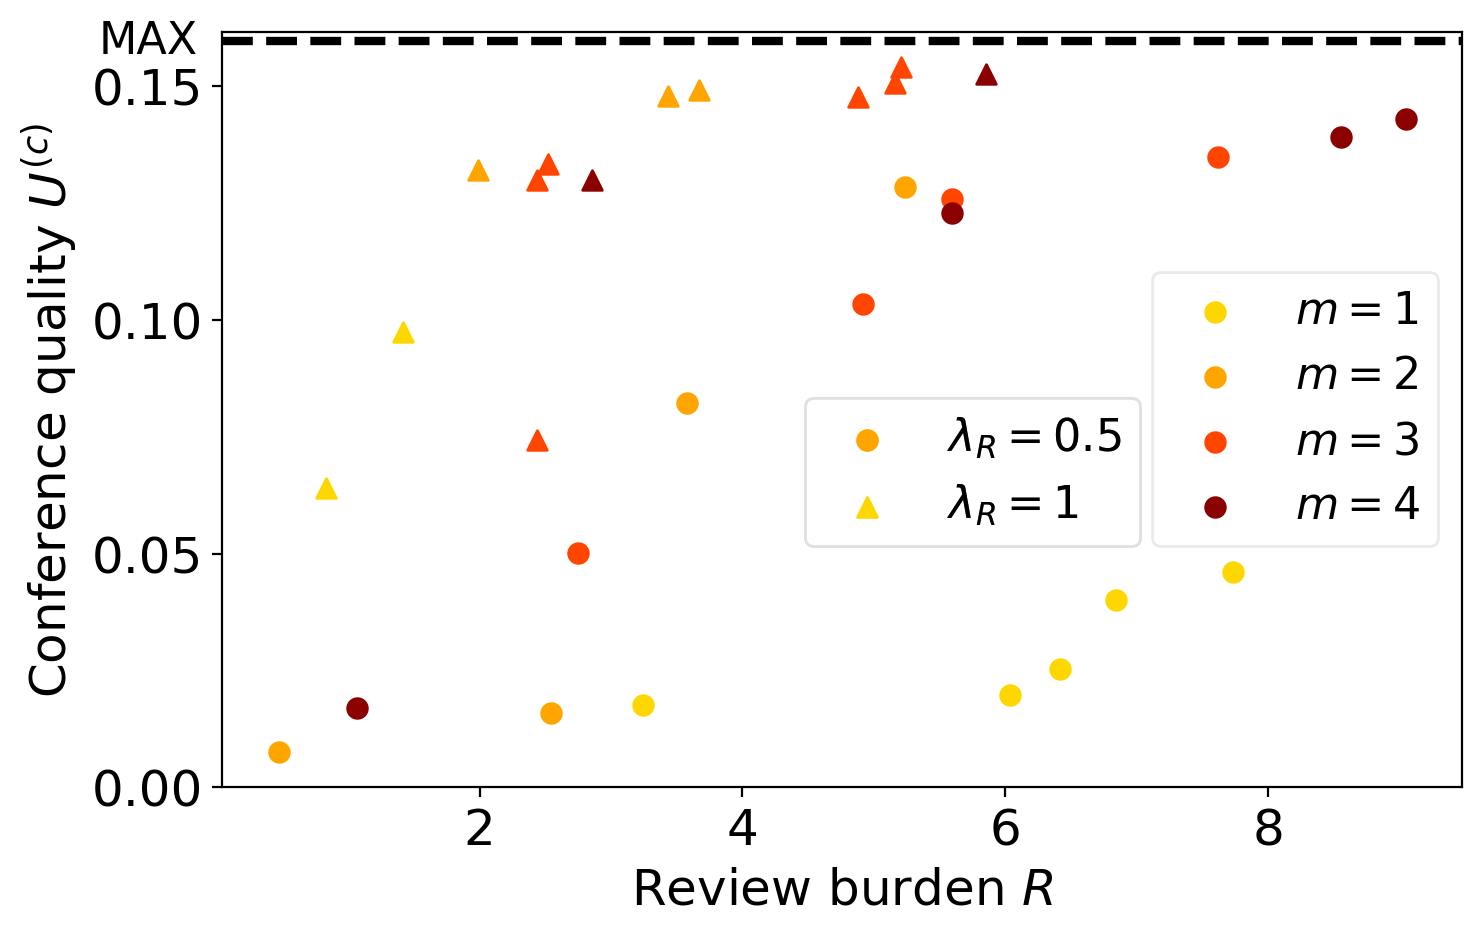

In [245]:
color = ['gold','orange','orangered','darkred']
Line = ['-','--','-.']
Marker = ['o','^','s']

Uc = np.load('Results/QB_tradeoff_noisy_20_L4/varying_m_3_Uc.npy')
R = np.load('Results/QB_tradeoff_noisy_20_L4/varying_m_3_R.npy')

plt.figure(figsize=(8,5), dpi= 200)
for i, lam_B in enumerate(lambda_range):
    for m in [1,2,3,4]:
        Uc_po, R_po,_ = Pareto_optimal(np.concatenate((Uc[i,m-1],[0])),np.concatenate((R[i,m-1],[0])))
        if i == 0:
            if m == 1:
                M1 = plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
            elif m == 2:
                M2 = plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
            elif m == 3:
                M3 = plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
            elif m == 4:
                M4 = plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
        else:
            if m == 1:
                lam_10 = plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
            else:
                plt.scatter(R_po, Uc_po, color = color[m-1], s = 50, marker=Marker[i])
        
legend1 = plt.legend([M1, M2, M3, M4], [r'$m=1$',r'$m=2$',r'$m=3$',r'$m=4$'], fontsize=16, loc = (0.75,0.32),framealpha = 0.4)
legend2 = plt.legend([M2,lam_10], [r'$\lambda_R=0.5$',r'$\lambda_R=1$'], fontsize=16, loc = (0.47,0.32),framealpha = 0.4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.yticks([0, 0.05, 0.1, 0.15])
plt.tick_params(labelsize=18)
plt.axhline(y=np.sum(w[2:]*Q[2:]), color='black', linestyle='--', linewidth = 3,zorder=0)
plt.text(-0.9,0.157,'MAX', fontsize=16, color='black')


## 3.4. Heatmap

We present a different view of the QB-tradeoff, where we use a heatmap to capture the largest conference quality that can be achieved given a review quality and review burden.

In [271]:
"""
Results are saved
"""
Gamma_A = Gamma
lambda_range = np.arange(0.3,1.01,0.05) # sample the review quality
tau_range = np.arange(min(Q),max(Q), 0.05)
V = 5
eta = 0.7
Uc = []
R = []
for i, lam_B in enumerate(lambda_range):
    print(lam_B)
    Gamma_B = lam_B*Gamma + (1-lam_B)*np.ones((L,10))/10
    Uc_m = []
    R_m = []
    
    # for each of the review quality, sample different m
    for m in [1,2,3,4,5]:
        Mapping_review_to_quality_noisy(Gamma_B, m)
        # sample the acceptance threshold
        for h, tau in enumerate(tau_range):
            initialization()
            for t in range(T):
                update()
            utility[np.where(papers==0)[0]] += np.power(eta,T) 
            papers[np.where(papers==0)[0]] = 3
            
            # conference quality
            u = 0
            for j in np.where(papers==2)[0]:
                u += Q[quality[j]]/n
            Uc_m.append(u)
            
            # review burden
            num_rev = np.zeros(n)
            for j in range(n):
                num_rev[j] = len(reviews_his[j])*m
            R_m.append(np.average(num_rev))
        
    Uc.append(Uc_m)
    R.append(R_m)
    
Uc = np.array(Uc)
R = np.array(R)
# np.save('Results/Heatmap_20_L4_noisy/Uc.npy', Uc)
# np.save('Results/Heatmap_20_L4_noisy/R.npy', R)

0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.5999999999999999
0.6499999999999999
0.7
0.7499999999999999
0.7999999999999998
0.8499999999999999
0.8999999999999999
0.95


In [296]:
"""
Transform to heatmap data
"""

Uc = np.load('Results/Heatmap_20_L4_noisy/Uc.npy')
R = np.load('Results/Heatmap_20_L4_noisy/R.npy')

lambda_range = np.arange(0.3,1.01,0.05) 
x_range = np.arange(0.3,1.01,0.01) # x-axis of the heatmap
y_range = np.arange(1,15.1,0.01) # y-axis of the heatmap
heatmap_data = np.zeros((len(y_range),len(x_range)))

### Generate heatmap
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):
        Uc_po, R_po, _ = Pareto_optimal(Uc[int(i/5)],R[int(i/5)]) # find the Pareto optimal points of the corresponding review quality
        R_sorted = np.sort(R_po)
        index_sorted = np.argsort(R_po)
        index = np.where(R_sorted <= y)[0] # find the indexes of Pareto optimal points whose review burden is no larger than y
        if len(index) > 0:
            heatmap_data[-j,i] = Uc_po[index_sorted[index[-1]]] # the value of the heatmap at (x,y) is achieved by the Pareto optimal point with the largest review burden (conditional on review burden is no larger than y)

# if a point on the heatmap has higher review quality and larger review burden than another point, it should be able to achieve at least as much conference quality.
# However, because the sampling of tau is not sufficient enough, the resutls do not necessarily guarantee this. 
# The following codes fix it.
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):
        if i > 1 and j > 1:
            max_color = np.max(heatmap_data[-(j-1):,0:i-1])
            if heatmap_data[-j,i] < max_color:
                heatmap_data[-j,i] = max_color
                

Text(141.44444444444443, 0.5, 'Review burden $R$')

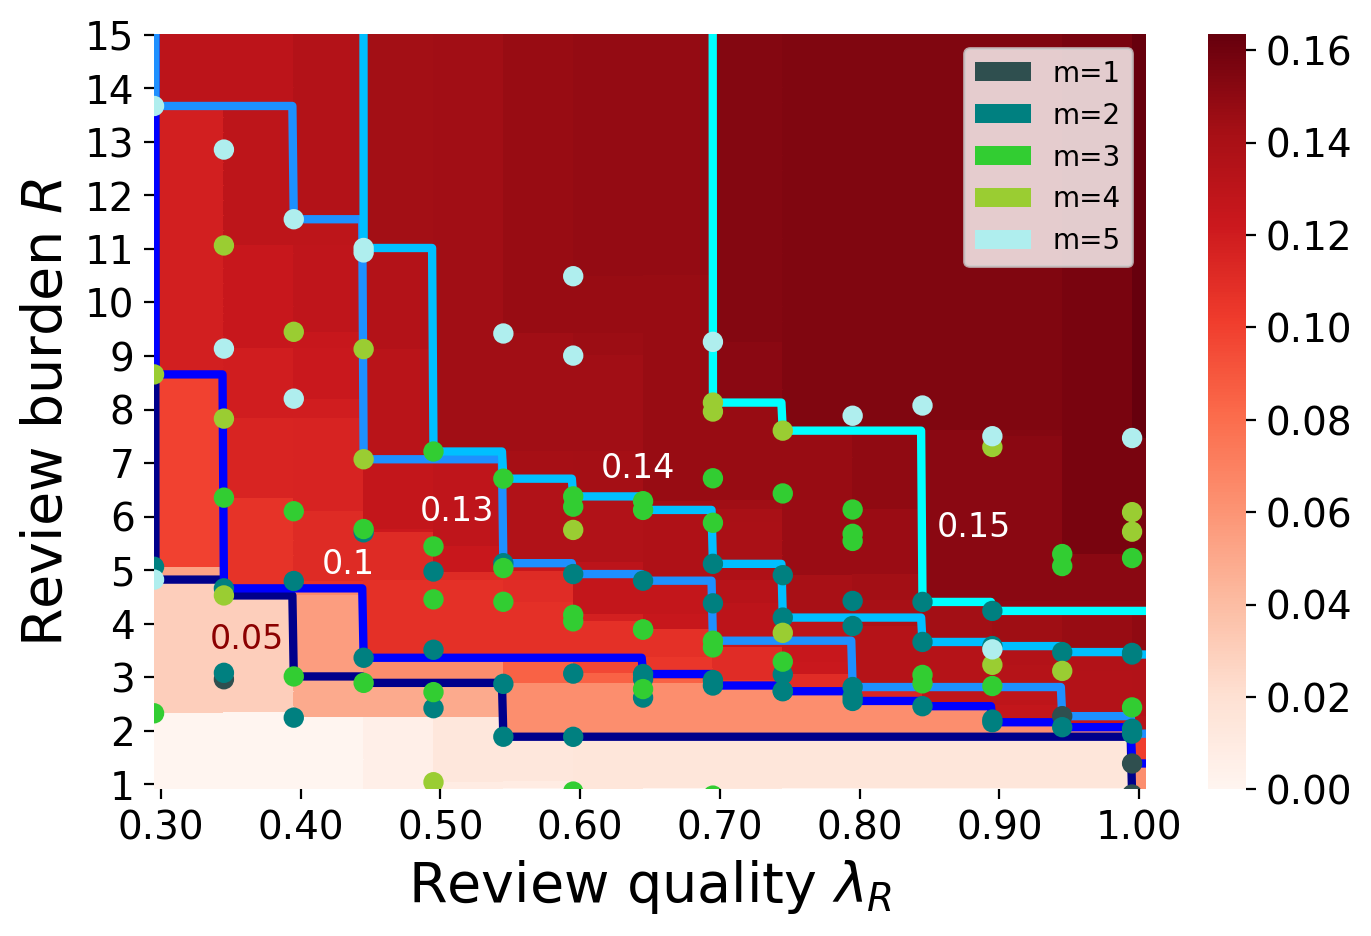

In [314]:
"""
Plot the heatmap
"""

def rearrange(x,y):
    """
    The function transforms the coordinates on heatmap into the coordinates on the scatter plot
    """
    return (x-0.3)*100, (15.1-y)*100

plt.figure(figsize=(8,5), dpi= 200)
df = pd.DataFrame(heatmap_data, index=list(np.flip(np.round(y_range,2))) ,columns=list(np.round(x_range,2)))
fig = sns.heatmap(df,xticklabels=10,yticklabels=100,cmap = 'Reds', cbar=True)
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

fig.set_xticklabels(xticklabels,fontsize=14)
fig.set_yticklabels(yticklabels,fontsize=14)


### scatter the strategy points
m_list = [] # store the number of solicited reviews for each acceptance threshold
for m in [1,2,3,4,5]:
    for h, tau in enumerate(tau_range):
        m_list.append(m)

Lam_list = []
U_Bob = []
N_review = []
M_list = []
boundary = []
for b in range(len(lambda_range)):
    Uc_po, R_po, index = Pareto_optimal(Uc[b],R[b])
    for i in index:
        if Uc[b,i] != 0:
            Lam_list.append(lambda_range[b])
            U_Bob.append(Uc[b,i])
            N_review.append(R[b,i])
            M_list.append(m_list[i])
M_list = np.array(M_list)
Lam_t, N_review_t = rearrange(np.array(Lam_list), np.array(N_review))
color_scatter = np.array(['darkslategrey','teal','limegreen','yellowgreen','paleturquoise'])
plt.scatter(Lam_t, N_review_t,
        s = 40,
        c = color_scatter[M_list-1],
        marker = 'o',
        zorder=2,
        label='k='+str(i))
legend_elements = [Patch(facecolor=color_scatter[i],label='m='+str(i+1)) for i in range(5)]
plt.legend(handles=legend_elements)

### Plot the contour
color_contour = ['cyan','deepskyblue','dodgerblue','blue','darkblue']
ub_list = [0.05,0.1,0.13,0.14,0.15]
x = np.arange(0.3,1.01,0.001)
y_max = 50
y = np.ones((len(ub_list),len(x)))*y_max
for i,u_b in enumerate(ub_list):
    boundary = []
    for b in range(len(lambda_range)):
        Up, Nr, index = Pareto_optimal(Uc[b],R[b])
        if len(np.where(Up >= u_b)[0]) > 0:
            if len(boundary) == 0:
                boundary.append([lambda_range[b], np.min(Nr[np.where(Up >= u_b)[0]])])
            elif np.min(Nr[np.where(Up >= u_b)[0]]) <= boundary[-1][1]:
                boundary.append([lambda_range[b], np.min(Nr[np.where(Up >= u_b)[0]])])
    boundary_np = np.array(boundary)
    for b, beta in enumerate(x):
        where = np.where(boundary_np[:,0] < beta)[0]
        if len(where) > 0:
            index = where[-1]
            y[i,b] = boundary_np[index,1]
for i in range(len(ub_list)):
    x_t, y_t = rearrange(x,y[i])
    plt.plot(x_t,y_t,linewidth = 3,color = color_contour[-i-1],zorder=1)

### Name the contour
plt.text((0.34-0.3)*100, (15.2-3.9)*100, '0.05', va='center',color = 'darkred',fontsize = 12)
plt.text((0.42-0.3)*100, (15.2-5.3)*100, '0.1', va='center',color = 'white',fontsize = 12)
plt.text((0.49-0.3)*100, (15.2-6.3)*100, '0.13', va='center',color = 'white',fontsize = 12)
plt.text((0.62-0.3)*100, (15.2-7.1)*100, '0.14', va='center',color = 'white',fontsize = 12)
plt.text((0.86-0.3)*100, (15.2-6)*100, '0.15', va='center',color = 'white',fontsize = 12)
    
_,lim = rearrange(1,np.array([1,13]))
plt.xlabel(r'Review quality $\lambda_R$',fontsize=20)
plt.ylabel(r'Review burden $R$',fontsize=20)